In [31]:
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pylab as plt
from math import ceil
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, ReLU, LeakyReLU, Dense
from keras.layers.core import Activation, Reshape
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Flatten
from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from tensorflow.keras.initializers import HeNormal
import keras.backend as K
from keras.initializers import RandomNormal
from keras.constraints import Constraint
import tensorflow as tf


In [32]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

In [33]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return K.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


In [34]:
def build_generator(z_dim = 128, n_filter = 64):
    init = RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    G = Sequential()
    G.add(Dense(2*2*n_filter*8, input_shape=(z_dim,), use_bias=True, kernel_initializer=init, kernel_constraint=const))
    # 2*2*512
    G.add(Reshape((2,2,n_filter*8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    # 4*4*256
    G.add(Conv2DTranspose(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init, kernel_constraint=const))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    # 8*8*128
    G.add(Conv2DTranspose(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init, kernel_constraint=const))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    # 16*16*64
    G.add(Conv2DTranspose(n_filter, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init, kernel_constraint=const))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    # 32*32*3
    G.add(Conv2DTranspose(3, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init, kernel_constraint=const))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    print('Build Generator')
    print(G.summary())
    return G

In [43]:
def build_discriminator(input_shape=(32,32,3), n_filter=64):
    init = RandomNormal(stddev=0.02)
    D = Sequential()
    # 16*16*64
    D.add(Conv2D(n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(LeakyReLU(0.2))
    # 8*8*64
    D.add(Conv2D(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    # 4*4*64
    D.add(Conv2D(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    # 2*2*64
    D.add(Conv2D(n_filter*8, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    D.add(Flatten())
    D.add(Dense(1, kernel_initializer=init))
    D.add(Activation('ReLU'))
    print('Build discriminator')
    print(D.summary())
    return D

In [44]:
def get_data():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = 2*(X_train/255)-1
    X_test = 2*(X_test/255)-1
    return X_train, X_test

In [45]:
def plot_images(images, filename):

    h, w, c = images.shape[1:]
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images + 1) / 2. * 255.
    images = images.astype(np.uint8)
    images = (images.reshape(grid_size, grid_size, h, w, c)
    
    .transpose(0, 2, 1, 3, 4)
    .reshape(grid_size*h, grid_size*w, c))
    
    #plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    plt.imshow(images)
    plt.show()

In [46]:
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    #plt.close()

In [47]:
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
 return K.mean(y_true * y_pred)

In [48]:
losses_d, losses_g = [], []

In [49]:
def train(n_filter=64, z_dim=100, lr_d= 1e-5, lr_g=3e-4, epochs=300, batch_size=128,

    epoch_per_checkpoint=1, n_checkpoint_images=36, verbose=10, n_critic=5):
    X_train,_ = get_data()
    image_shape = X_train[0].shape
    print('Image shape {}, min val {}, max val {}'.format(image_shape, np.min(X_train[0]), np.max(X_train[0])))
    plot_images(X_train[:n_checkpoint_images], 'real_image.png')
    # Build model
    G = build_generator(z_dim, n_filter)
    D = build_discriminator(image_shape, n_filter)
    # Loss for discriminator
    D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss=wasserstein_loss, metrics=['binary_accuracy'])
    # D(G(X))
    D.trainable = False
    z = Input(shape=(z_dim,))
    D_of_G = Model(inputs=z, outputs=D(G(z)))
    # Loss for generator
    D_of_G.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss=wasserstein_loss, metrics=['binary_accuracy'])
    # Labels for computing the losses
    half_batch_size = batch_size // 2 
    real_labels = -np.ones(shape=(half_batch_size, 1)) # -1
    fake_labels = np.ones(shape=(half_batch_size, 1))  # 1

    real_labels_gan = np.ones(shape=(batch_size, 1))
    
    n_steps = X_train.shape[0]//batch_size
    
    # fix a z vector for training evaluation 
    z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
    
    for e in tqdm(range(1, epochs+1)):
        for i in range(n_steps):
            D.trainable = True
            loss_d = 0
            for _ in range(n_critic):
                # Train discriminator
                real_images = X_train[np.random.randint(0, X_train.shape[0], size=half_batch_size)]
                loss_d_real = D.train_on_batch(x=real_images, y=real_labels)[0]
                z = np.random.uniform(-1, 1, size=(half_batch_size, z_dim))
                fake_images = G.predict_on_batch(z)
                loss_d_fake = D.train_on_batch(x=fake_images, y=fake_labels)[0]
                loss_d += loss_d_real + loss_d_fake
            
            loss_d /= n_critic
            
            # Train generator
            D.trainable = False
            z_G = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            loss_g = D_of_G.train_on_batch(x=z_G, y=real_labels_gan)[0]
            losses_d.append(loss_d)
            losses_g.append(loss_g)
            
            if i == 0 and e%verbose == 0:
                print('Epoch {}'.format(e))
                fake_images = G.predict(z_fixed)
                #print("\tPlotting images and losses")
                plot_images(fake_images, "Images1/fake_images_e_{}.png".format(e))
                plot_losses(losses_d, losses_g, "losses.png")


Image shape (32, 32, 3), min val -1.0, max val 1.0


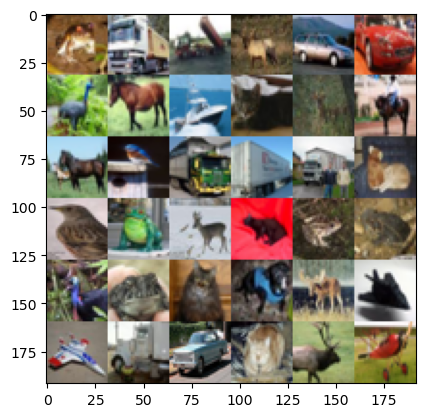

Build Generator
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2048)              206848    
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 batch_normalization_8 (Batc  (None, 2, 2, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4, 4, 256)        3277056   
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 4

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
train()

In [1]:
#Xoa bo dem
import tensorflow as tf
tf.keras.backend.clear_session()

import torch
torch.cuda.empty_cache()

In [3]:
print(losses_d)

NameError: name 'losses_d' is not defined